<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Armin Ghasemi</b><br><br>810100198</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>deep learning </b><br><br>HW_2 Q2</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Amirhossein samoudi </b><br><br>810100108</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
        </table>
    </div>
</div>


# A Hybrid Deep Learning VGG-16 Based SVM Model for Vehicle Type Classification

## 2-2: Preprocessing of the data

### Frequency plot of classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import os
import matplotlib.pyplot as plt
import shutil
import random
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models
from torchvision.models import VGG16_Weights
from torchvision.models import AlexNet_Weights
from tqdm import tqdm
import re
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


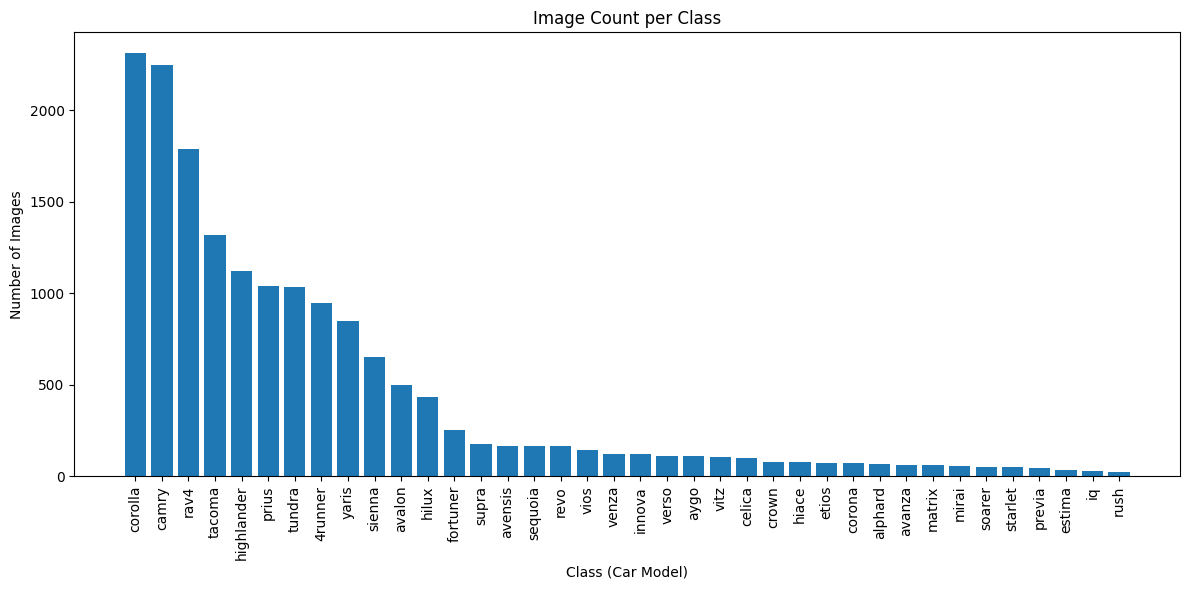

In [ ]:
base_path = "/content/drive/My Drive/Colab Notebooks/HW2/toyota_image_dataset_v2/toyota_cars"

class_counts = {}
for class_name in os.listdir(base_path):
    class_dir = os.path.join(base_path, class_name)
    if os.path.isdir(class_dir):
        image_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[class_name] = image_count

sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Class (Car Model)")
plt.ylabel("Number of Images")
plt.title("Image Count per Class")
plt.tight_layout()
plt.show()



### Select 10 classes

In [ ]:


dataset_path = "/content/drive/My Drive/Colab Notebooks/HW2/toyota_selected_classes"

if not os.path.exists(dataset_path):
    selected_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)[13:23]
    selected_class_names = [name for name, _ in selected_classes]

    os.makedirs(dataset_path, exist_ok=True)

    for class_name in selected_class_names:
        src_folder = os.path.join(base_path, class_name)
        dst_folder = os.path.join(dataset_path, class_name)
        os.makedirs(dst_folder, exist_ok=True)

        for img_file in os.listdir(src_folder):
            src_file = os.path.join(src_folder, img_file)
            dst_file = os.path.join(dst_folder, img_file)
            if os.path.isfile(src_file):
                shutil.copy2(src_file, dst_file)

    print("New base path created:", dataset_path)
else:
    print("Dataset folder already exists, skipping creation.")


New base path created: /content/drive/My Drive/Colab Notebooks/HW2/toyota_selected_classes


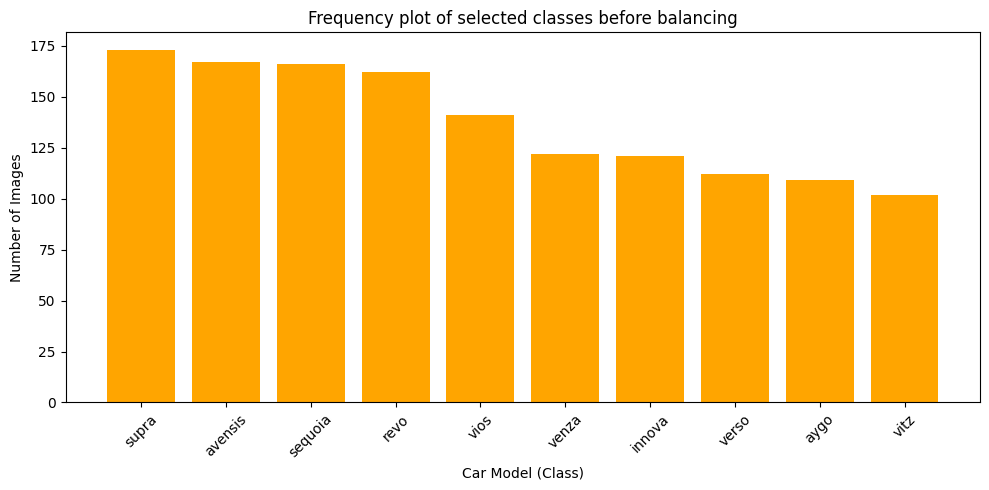

In [ ]:
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[class_name] = count

sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='orange')
plt.xticks(rotation=45)
plt.xlabel("Car Model (Class)")
plt.ylabel("Number of Images")
plt.title("Frequency plot of selected classes before balancing")
plt.tight_layout()
plt.show()

### Balancing the classes (data augmentation)

In [ ]:
target_count = 300

augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
])


for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    current_count = len(image_files)

    if current_count >= target_count:
        continue

    images_needed = target_count - current_count
    print(f"Augmenting {images_needed} images for class '{class_name}'...")

    for i in range(images_needed):
        img_file = random.choice(image_files)
        img_path = os.path.join(class_dir, img_file)

        image = Image.open(img_path).convert("RGB")
        augmented_image = augmentation_transforms(image)

        new_filename = f"aug_{i}_{img_file}"
        new_path = os.path.join(class_dir, new_filename)
        augmented_image.save(new_path)



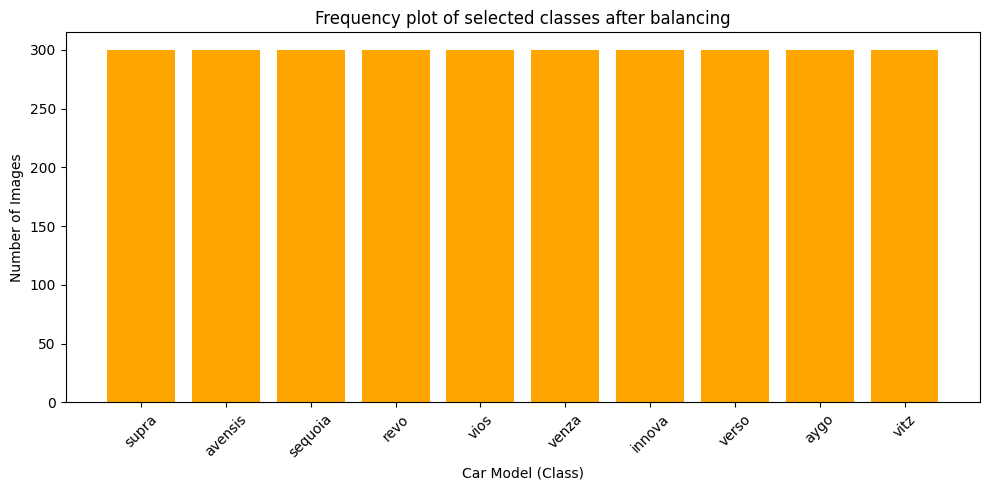

In [ ]:
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[class_name] = count

sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='orange')
plt.xticks(rotation=45)
plt.xlabel("Car Model (Class)")
plt.ylabel("Number of Images")
plt.title("Frequency plot of selected classes after balancing")
plt.tight_layout()
plt.show()

### Resizing and normalizing

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print("Class to index mapping:", dataset.class_to_idx)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Class to index mapping: {'avensis': 0, 'aygo': 1, 'innova': 2, 'revo': 3, 'sequoia': 4, 'supra': 5, 'venza': 6, 'verso': 7, 'vios': 8, 'vitz': 9}
Total samples: 3000
Training samples: 2400
Testing samples: 600
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


## 2-3: Extracting features

### VGG-16

In [ ]:
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)

vgg16_features = vgg16.features
vgg16_features.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_features = vgg16_features.to(device)

def extract_and_save_features(loader, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (images, labels) in enumerate(tqdm(loader)):
        images = images.to(device)
        with torch.no_grad():
            features = vgg16_features(images)

        for j in range(images.size(0)):
            feature = features[j].view(-1).cpu()
            label = labels[j].item()
            save_path = os.path.join(save_dir, f"img_{i}_{j}_label{label}.pt")
            torch.save(feature, save_path)

extract_and_save_features(train_loader, "/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/train")
extract_and_save_features(test_loader, "/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/test")


100%|██████████| 19/19 [00:11<00:00,  1.70it/s]


### Alex Net

In [ ]:
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
alexnet_features = alexnet.features
alexnet_features.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_features = alexnet_features.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 171MB/s]


In [ ]:
def extract_alexnet_features(loader, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    for i, (images, labels) in enumerate(tqdm(loader, desc=f"Extracting to {save_dir}")):
        images = images.to(device)
        with torch.no_grad():
            features = alexnet_features(images)

        for j in range(images.size(0)):
            feature = features[j].view(-1).cpu()
            label = labels[j].item()
            save_path = os.path.join(save_dir, f"img_{i}_{j}_label{label}.pt")
            torch.save(feature, save_path)

extract_alexnet_features(train_loader, "/content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/train")
extract_alexnet_features(test_loader, "/content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/test")


Extracting to /content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/train: 100%|██████████| 75/75 [00:41<00:00,  1.83it/s]
Extracting to /content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/test: 100%|██████████| 19/19 [00:08<00:00,  2.16it/s]


## 2-4: Train and evaluate models

### 1: VGG-16

#### Load data set

In [50]:
class VGGFeatureDataset(Dataset):
    def __init__(self, feature_dir):
        self.feature_paths = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.pt')]
        self.labels = [int(re.search(r'label(\d+)', f).group(1)) for f in self.feature_paths]

    def __len__(self):
        return len(self.feature_paths)

    def __getitem__(self, idx):
        feature = torch.load(self.feature_paths[idx], weights_only=True)
        label = self.labels[idx]
        return feature, label

train_features_vgg = VGGFeatureDataset("/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/train")
test_features_vgg = VGGFeatureDataset("/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/test")

train_loader_vgg = DataLoader(train_features_vgg, batch_size=32, shuffle=True)
test_loader_vgg = DataLoader(test_features_vgg, batch_size=32, shuffle=False)

#### Classifier

In [ ]:
class VGGClassifier(nn.Module):
    def __init__(self, input_dim=25088, hidden_dim=512, num_classes=10, dropout_prob=0.3):
        super(VGGClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


#### Train

Epoch [1/30] | Train Loss: 2.0623 | Val Loss: 2.0425 | Val Accuracy: 0.4053
Epoch [2/30] | Train Loss: 0.7270 | Val Loss: 0.7058 | Val Accuracy: 0.7667
Epoch [3/30] | Train Loss: 0.3665 | Val Loss: 0.3739 | Val Accuracy: 0.8933
Epoch [4/30] | Train Loss: 0.2040 | Val Loss: 0.2390 | Val Accuracy: 0.9453
Epoch [5/30] | Train Loss: 0.1406 | Val Loss: 0.1191 | Val Accuracy: 0.9653
Epoch [6/30] | Train Loss: 0.0790 | Val Loss: 0.0534 | Val Accuracy: 0.9907
Epoch [7/30] | Train Loss: 0.0512 | Val Loss: 0.0390 | Val Accuracy: 0.9880
Epoch [8/30] | Train Loss: 0.0278 | Val Loss: 0.0344 | Val Accuracy: 0.9933
Epoch [9/30] | Train Loss: 0.0245 | Val Loss: 0.0232 | Val Accuracy: 0.9960
Epoch [10/30] | Train Loss: 0.0243 | Val Loss: 0.0169 | Val Accuracy: 0.9973
Epoch [11/30] | Train Loss: 0.0237 | Val Loss: 0.0143 | Val Accuracy: 0.9987
Epoch [12/30] | Train Loss: 0.0179 | Val Loss: 0.0179 | Val Accuracy: 0.9973
Epoch [13/30] | Train Loss: 0.0157 | Val Loss: 0.0161 | Val Accuracy: 0.9960
Epoch [1

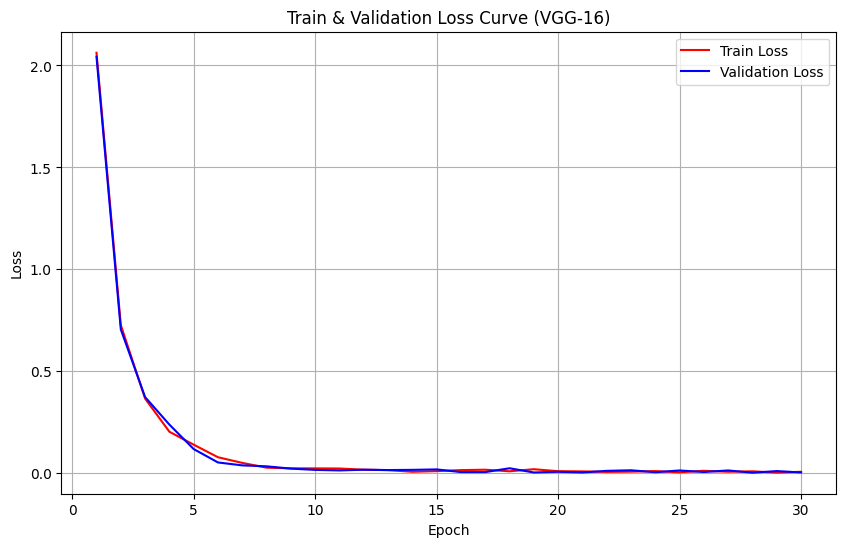

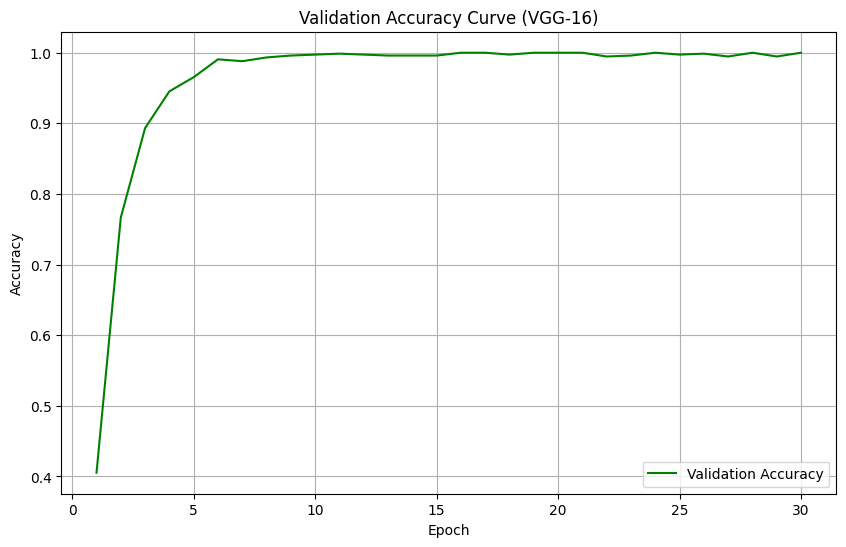

In [ ]:
vgg_model = VGGClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-3,  weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    vgg_model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    for features, labels in train_loader_vgg:
        features, labels = features.to(device), labels.to(device)

        batch_size = features.size(0)
        indices = list(range(batch_size))
        random.shuffle(indices)

        split = int(batch_size * 0.7)
        train_idx, val_idx = indices[:split], indices[split:]

        features_train, labels_train = features[train_idx], labels[train_idx]
        features_val, labels_val = features[val_idx], labels[val_idx]

        optimizer.zero_grad()
        outputs_train = vgg_model(features_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        running_train_loss += loss_train.item()

        with torch.no_grad():
            outputs_val = vgg_model(features_val)
            loss_val = criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item()

            _, predicted_val = torch.max(outputs_val, 1)
            all_val_preds.extend(predicted_val.cpu().numpy())
            all_val_labels.extend(labels_val.cpu().numpy())

    avg_train_loss = running_train_loss / len(train_loader_vgg)
    avg_val_loss = running_val_loss / len(train_loader_vgg)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': vgg_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, checkpoint_path)
    scheduler.step()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='r')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Curve (VGG-16)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve (VGG-16)")
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation

In [ ]:
vgg_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader_vgg:
        features = features.to(device)
        outputs = vgg_model(features)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

vgg_metrics = [accuracy, precision, recall, f1]

print("VGG-16 metrics:")
print("Accuracy:", vgg_metrics[0])
print("Precision:", vgg_metrics[1])
print("Recall:", vgg_metrics[2])
print("F1 Score:", vgg_metrics[3])

VGG-16 metrics:
Accuracy: 0.8516666666666667
Precision: 0.8528605521739642
Recall: 0.8516666666666667
F1 Score: 0.8515066364461905


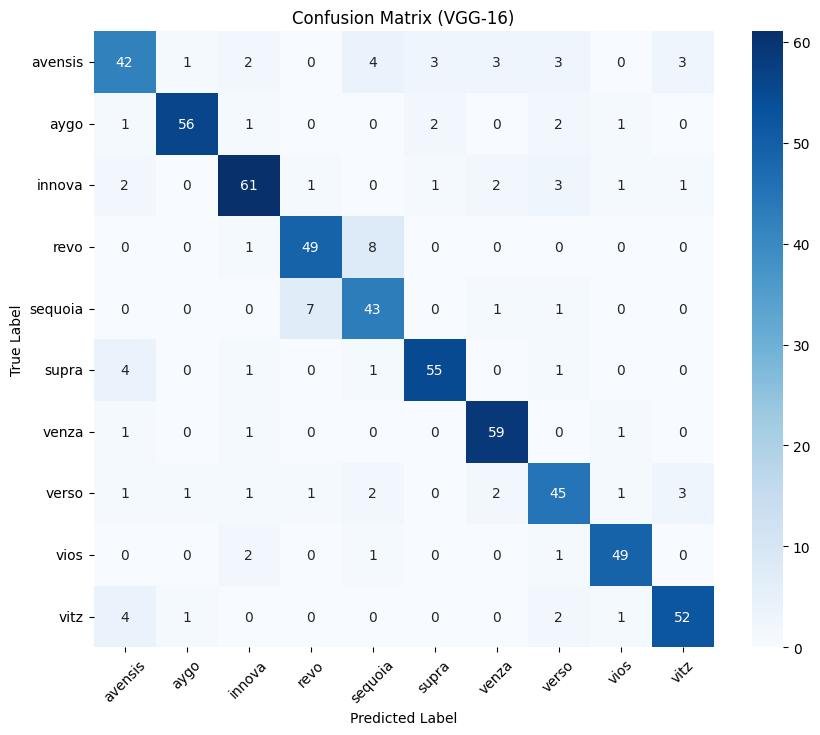

In [ ]:
def plot_confusion_matrix(model, test_loader, class_to_idx,model_name, num_classes=10):
    model.eval()
    all_preds = []
    all_labels = []

    class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(vgg_model, test_loader_vgg, dataset.class_to_idx, model_name="VGG-16", num_classes=10)


### 2: Alex Net

#### Load data set

In [ ]:
class AlexNetFeatureDataset(Dataset):
    def __init__(self, feature_dir):
        self.feature_paths = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith('.pt')]

        self.labels = [int(re.search(r'label(\d+)', f).group(1)) for f in self.feature_paths]

    def __len__(self):
        return len(self.feature_paths)
    def __getitem__(self, idx):
        feature = torch.load(self.feature_paths[idx],weights_only=True )
        label = self.labels[idx]
        return feature, label

train_features_alexnet = AlexNetFeatureDataset("/content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/train")
test_features_alexnet = AlexNetFeatureDataset("/content/drive/My Drive/Colab Notebooks/HW2/alexnet_features/test")

train_loader_alexnet = DataLoader(train_features_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = DataLoader(test_features_alexnet, batch_size=32, shuffle=False)


#### Classifier

In [ ]:
class AlexNetClassifier(nn.Module):
    def __init__(self, input_dim=9216, hidden_dim=512, num_classes=10, dropout_prob=0.3):
        super(AlexNetClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


#### Train

Epoch [1/30] | Train Loss: 2.3830 | Val Loss: 2.3988 | Val Accuracy: 0.3040
Epoch [2/30] | Train Loss: 1.3607 | Val Loss: 1.2829 | Val Accuracy: 0.5467
Epoch [3/30] | Train Loss: 0.9924 | Val Loss: 0.8994 | Val Accuracy: 0.7053
Epoch [4/30] | Train Loss: 0.7212 | Val Loss: 0.7524 | Val Accuracy: 0.7627
Epoch [5/30] | Train Loss: 0.5163 | Val Loss: 0.5007 | Val Accuracy: 0.8467
Epoch [6/30] | Train Loss: 0.3105 | Val Loss: 0.3157 | Val Accuracy: 0.9040
Epoch [7/30] | Train Loss: 0.2392 | Val Loss: 0.2313 | Val Accuracy: 0.9373
Epoch [8/30] | Train Loss: 0.1872 | Val Loss: 0.1988 | Val Accuracy: 0.9493
Epoch [9/30] | Train Loss: 0.1509 | Val Loss: 0.1456 | Val Accuracy: 0.9720
Epoch [10/30] | Train Loss: 0.1148 | Val Loss: 0.1383 | Val Accuracy: 0.9667
Epoch [12/30] | Train Loss: 0.0860 | Val Loss: 0.0670 | Val Accuracy: 0.9960
Epoch [13/30] | Train Loss: 0.0771 | Val Loss: 0.0688 | Val Accuracy: 0.9907
Epoch [14/30] | Train Loss: 0.0713 | Val Loss: 0.0835 | Val Accuracy: 0.9840
Epoch [1

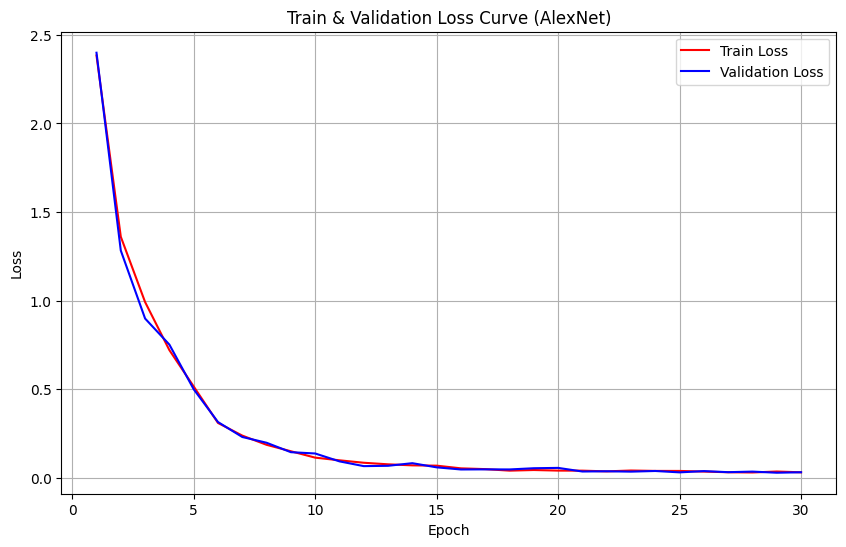

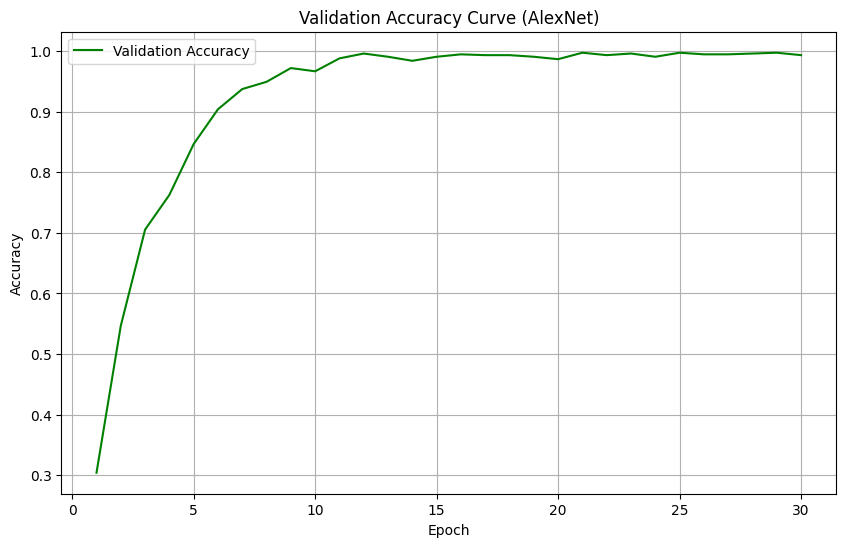

In [ ]:
alex_model = AlexNetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0
checkpoint_dir = "./checkpoints_alexnet"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    alex_model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    for features, labels in train_loader_alexnet:
        features, labels = features.to(device), labels.to(device)

        batch_size = features.size(0)
        indices = list(range(batch_size))
        random.shuffle(indices)

        split = int(batch_size * 0.7)
        train_idx, val_idx = indices[:split], indices[split:]

        features_train, labels_train = features[train_idx], labels[train_idx]
        features_val, labels_val = features[val_idx], labels[val_idx]

        optimizer.zero_grad()
        outputs_train = alex_model(features_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        running_train_loss += loss_train.item()

        with torch.no_grad():
            outputs_val = alex_model(features_val)
            loss_val = criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item()

            _, predicted_val = torch.max(outputs_val, 1)
            all_val_preds.extend(predicted_val.cpu().numpy())
            all_val_labels.extend(labels_val.cpu().numpy())

    avg_train_loss = running_train_loss / len(train_loader_alexnet)
    avg_val_loss = running_val_loss / len(train_loader_alexnet)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': alex_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, checkpoint_path)

    scheduler.step()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='r')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Curve (AlexNet)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='g')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve (AlexNet)")
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation

In [ ]:
alex_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader_alexnet:
        features = features.to(device)
        outputs = alex_model(features)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

alex_metrics = [accuracy, precision, recall, f1]

print("Alex Net metrics:")
print("Accuracy:", alex_metrics[0])
print("Precision:", alex_metrics[1])
print("Recall:", alex_metrics[2])
print("F1 Score:", alex_metrics[3])

Alex Net metrics:
Accuracy: 0.7866666666666666
Precision: 0.7900288346827894
Recall: 0.7866666666666666
F1 Score: 0.7872907629154676


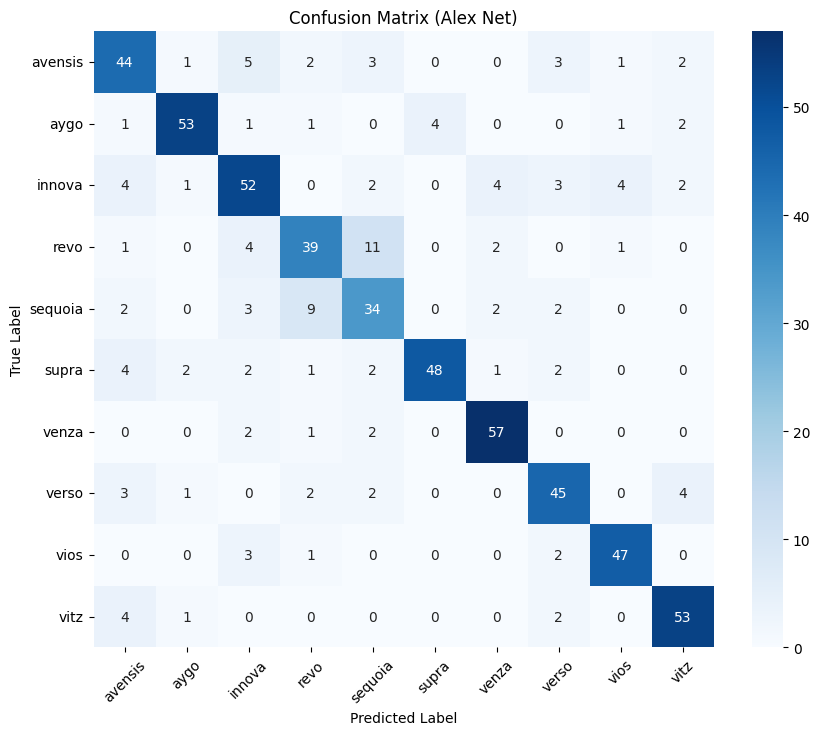

In [ ]:
plot_confusion_matrix(alex_model, test_loader_alexnet, dataset.class_to_idx,model_name="Alex Net", num_classes=10)

### 3: CNN

#### Model architecture

In [58]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9, padding=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)

        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


#### Train

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/60] | Train Loss: 2.3043 | Val Loss: 2.3113 | Val Accuracy: 0.1107
Epoch [2/60] | Train Loss: 2.3051 | Val Loss: 2.3029 | Val Accuracy: 0.0907
Epoch [3/60] | Train Loss: 2.3032 | Val Loss: 2.3043 | Val Accuracy: 0.1013
Epoch [4/60] | Train Loss: 2.3010 | Val Loss: 2.3093 | Val Accuracy: 0.0960
Epoch [5/60] | Train Loss: 2.3037 | Val Loss: 2.3028 | Val Accuracy: 0.1200
Epoch [6/60] | Train Loss: 2.2611 | Val Loss: 2.2596 | Val Accuracy: 0.1600
Epoch [7/60] | Train Loss: 2.2522 | Val Loss: 2.2215 | Val Accuracy: 0.1560
Epoch [8/60] | Train Loss: 2.1949 | Val Loss: 2.1874 | Val Accuracy: 0.1693
Epoch [9/60] | Train Loss: 2.1624 | Val Loss: 2.1512 | Val Accuracy: 0.1893
Epoch [10/60] | Train Loss: 2.1355 | Val Loss: 2.1684 | Val Accuracy: 0.1760
Epoch [11/60] | Train Loss: 2.0842 | Val Loss: 2.1313 | Val Accuracy: 0.2227
Epoch [12/60] | Train Loss: 2.0626 | Val Loss: 2.0411 | Val Accuracy: 0.2440
Epoch [13/60] | Train Loss: 1.9910 | Val Loss: 2.0156 | Val Accuracy: 0.2867
Epoch [1

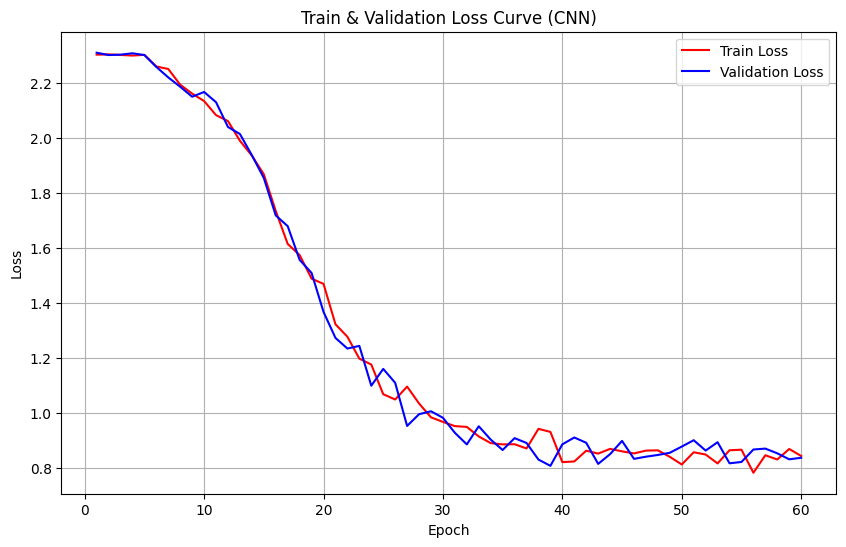

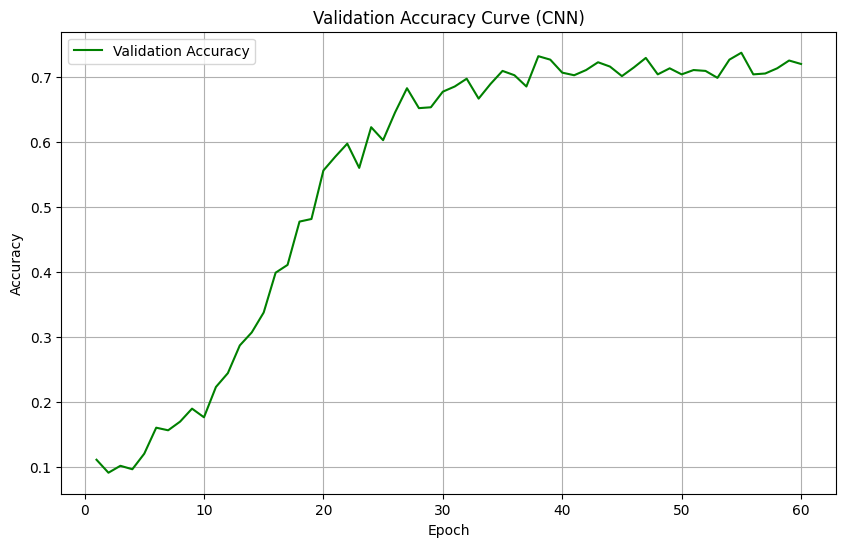

In [59]:
cnn_model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 60
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0
checkpoint_dir = "./checkpoints_cnn"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    cnn_model.train()
    running_train_loss = 0.0
    running_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        batch_size = images.size(0)
        indices = list(range(batch_size))
        random.shuffle(indices)

        split = int(batch_size * 0.7)
        train_idx, val_idx = indices[:split], indices[split:]

        images_train, labels_train = images[train_idx], labels[train_idx]
        images_val, labels_val = images[val_idx], labels[val_idx]

        optimizer.zero_grad()
        outputs_train = cnn_model(images_train)
        loss_train = criterion(outputs_train, labels_train)
        loss_train.backward()
        optimizer.step()

        running_train_loss += loss_train.item()

        with torch.no_grad():
            outputs_val = cnn_model(images_val)
            loss_val = criterion(outputs_val, labels_val)
            running_val_loss += loss_val.item()

            _, predicted_val = torch.max(outputs_val, 1)
            all_val_preds.extend(predicted_val.cpu().numpy())
            all_val_labels.extend(labels_val.cpu().numpy())

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(train_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': cnn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, checkpoint_path)

    scheduler.step()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Curve (CNN)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve (CNN)")
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation

In [60]:
cnn_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = cnn_model(features)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

cnn_metrics = [accuracy, precision, recall, f1]

print("CNN metrics:")
print("Accuracy:", cnn_metrics[0])
print("Precision:", cnn_metrics[1])
print("Recall:", cnn_metrics[2])
print("F1 Score:", cnn_metrics[3])

CNN metrics:
Accuracy: 0.49333333333333335
Precision: 0.49751213269353056
Recall: 0.49333333333333335
F1 Score: 0.4908417432678942


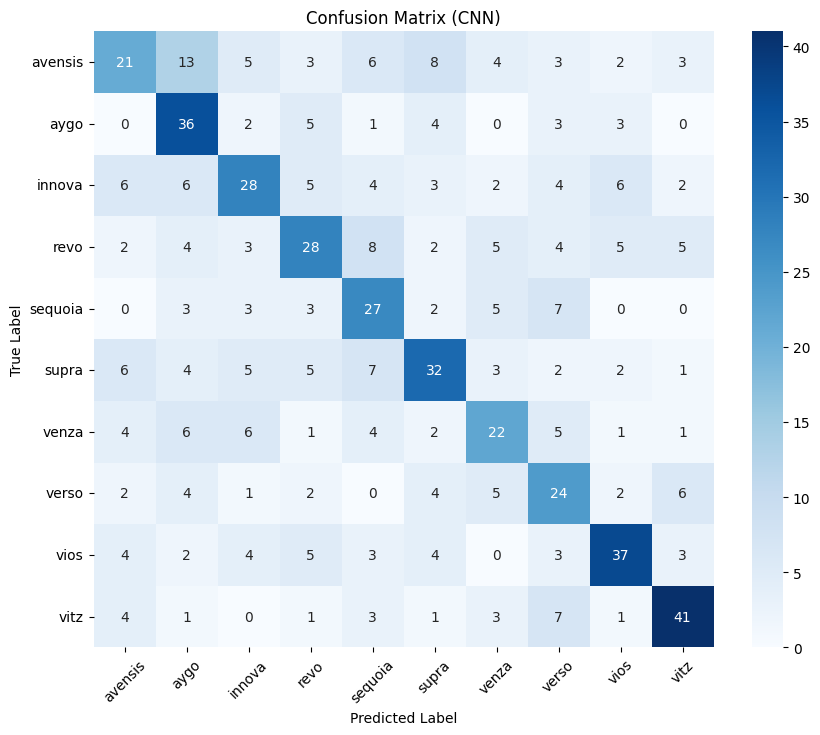

In [63]:
plot_confusion_matrix(cnn_model, test_loader, dataset.class_to_idx, model_name="CNN", num_classes=10)

### 4: VGG + SVM

#### Load data set

In [65]:
class VGGFeatureDatasetForSVM(Dataset):
    def __init__(self, feature_dir):
        self.feature_paths = [os.path.join(feature_dir, f)
                              for f in os.listdir(feature_dir) if f.endswith('.pt')]
        self.labels = [int(re.search(r'label(\d+)', f).group(1)) for f in self.feature_paths]

    def __len__(self):
        return len(self.feature_paths)

    def __getitem__(self, idx):
        feature = torch.load(self.feature_paths[idx], weights_only=True)
        label = self.labels[idx]
        return feature.view(-1), label

train_features_vgg_svm = VGGFeatureDatasetForSVM("/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/train")
test_features_vgg_svm = VGGFeatureDatasetForSVM("/content/drive/My Drive/Colab Notebooks/HW2/vgg16_features/test")

def extract_features_and_labels(dataset):
    features, labels = [], []
    for x, y in dataset:
        features.append(x.numpy())
        labels.append(y)
    return features, labels

X_train_vgg, y_train_vgg = extract_features_and_labels(train_features_vgg_svm)
X_test_vgg, y_test_vgg = extract_features_and_labels(test_features_vgg_svm)


#### Define SVM classifier and train

In [ ]:
svm_model = SVC(kernel='linear')

svm_model.fit(X_train_vgg, y_train_vgg)

y_pred_vgg = svm_model.predict(X_test_vgg)

In [ ]:
accuracy = accuracy_score(y_test_vgg, y_pred_vgg)
precision = precision_score(y_test_vgg, y_pred_vgg, average='weighted')
recall = recall_score(y_test_vgg, y_pred_vgg, average='weighted')
f1 = f1_score(y_test_vgg, y_pred_vgg, average='weighted')


svm_metrics = [accuracy, precision, recall, f1]

print("VGG-16 + SVM metrics")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_vgg, y_pred_vgg))

print("\nClassification Report:")
print(classification_report(y_test_vgg, y_pred_vgg))


VGG-16 + SVM metrics
Accuracy: 0.825
Precision: 0.8257123528643637
Recall: 0.825
F1 Score: 0.8244340710924798

Confusion Matrix:
[[41  1  2  2  2  3  2  6  1  1]
 [ 0 55  0  0  0  1  0  4  2  1]
 [ 3  1 58  2  1  0  4  2  0  1]
 [ 1  1  3 43  9  0  1  0  0  0]
 [ 0  0  0 10 42  0  0  0  0  0]
 [ 3  0  0  0  1 53  1  1  2  1]
 [ 1  0  2  0  0  0 59  0  0  0]
 [ 2  3  0  0  1  0  2 44  0  5]
 [ 1  0  1  0  0  0  1  0 49  1]
 [ 4  1  1  0  0  0  0  2  1 51]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        61
           1       0.89      0.87      0.88        63
           2       0.87      0.81      0.83        72
           3       0.75      0.74      0.75        58
           4       0.75      0.81      0.78        52
           5       0.93      0.85      0.89        62
           6       0.84      0.95      0.89        62
           7       0.75      0.77      0.76        57
           8       0.89      

<Figure size 1000x800 with 0 Axes>

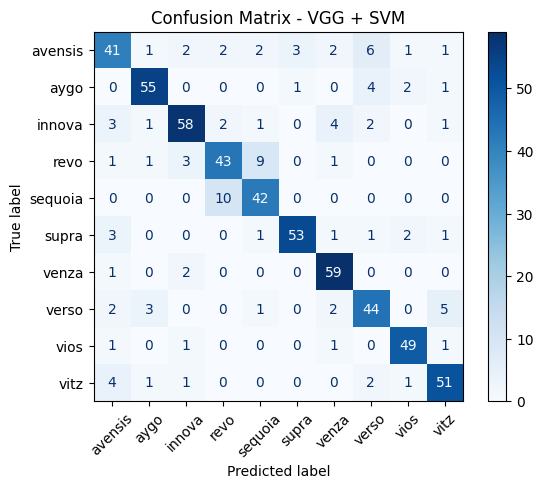

In [ ]:
cm = confusion_matrix(y_test_vgg, y_pred_vgg)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - VGG + SVM")
plt.grid(False)
plt.show()


## 2-5: Analyze results

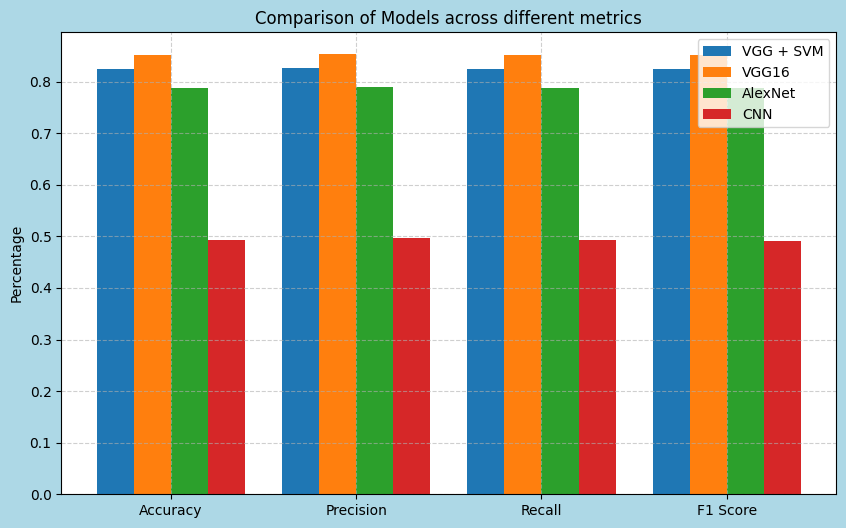

In [64]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

x = np.arange(len(metrics_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, svm_metrics, width, label='VGG + SVM')
rects2 = ax.bar(x - 0.5*width, vgg_metrics, width, label='VGG16')
rects3 = ax.bar(x + 0.5*width, alex_metrics, width, label='AlexNet')
rects4 = ax.bar(x + 1.5*width, cnn_metrics, width, label='CNN')

ax.set_ylabel('Percentage')
ax.set_title('Comparison of Models across different metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.6)
fig.patch.set_facecolor('lightblue')
ax.set_facecolor('white')
plt.show()


## Bonus: SVM using different kernels

In [71]:
rbf_svm_model = SVC(kernel='rbf')

rbf_svm_model.fit(X_train_vgg, y_train_vgg)
y_pred_vgg = rbf_svm_model.predict(X_test_vgg)

In [72]:
accuracy = accuracy_score(y_test_vgg, y_pred_vgg)
precision = precision_score(y_test_vgg, y_pred_vgg, average='weighted')
recall = recall_score(y_test_vgg, y_pred_vgg, average='weighted')
f1 = f1_score(y_test_vgg, y_pred_vgg, average='weighted')


rbf_svm_metrics = [accuracy, precision, recall, f1]

print("VGG-16 + SVM metrics(RBF Kernel)")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_vgg, y_pred_vgg))

print("\nClassification Report:")
print(classification_report(y_test_vgg, y_pred_vgg))

VGG-16 + SVM metrics(RBF Kernel)
Accuracy: 0.7383333333333333
Precision: 0.7468261945577734
Recall: 0.7383333333333333
F1 Score: 0.7390604939719709

Confusion Matrix:
[[35  0  2  2  2  3  7  5  1  4]
 [ 0 49  1  3  0  1  0  5  4  0]
 [ 3  0 51  4  1  0  3  6  4  0]
 [ 1  0  4 39 10  0  1  1  2  0]
 [ 1  0  1 11 37  0  1  0  0  1]
 [ 5  1  0  1  1 46  3  2  2  1]
 [ 1  0  5  1  0  0 54  1  0  0]
 [ 3  1  1  2  1  0  3 39  1  6]
 [ 2  0  0  0  0  0  2  1 48  0]
 [ 6  3  0  0  0  0  0  3  3 45]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        61
           1       0.91      0.78      0.84        63
           2       0.78      0.71      0.74        72
           3       0.62      0.67      0.64        58
           4       0.71      0.71      0.71        52
           5       0.92      0.74      0.82        62
           6       0.73      0.87      0.79        62
           7       0.62      0.68      0.65  

<Figure size 1000x800 with 0 Axes>

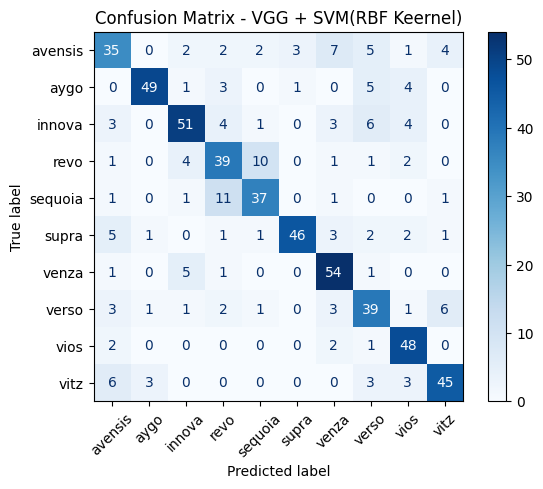

In [73]:
cm = confusion_matrix(y_test_vgg, y_pred_vgg)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - VGG + SVM(RBF Keernel)")
plt.grid(False)
plt.show()